<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [ ]:
#!pip install --upgrade --no-cache-dir gdown --quiet
!pip install Fasttext
!pip install imbalanced-learn

In [ ]:
import numpy as np
import random
import io
import pickle
import pandas as pd
from keras.preprocessing.text import Tokenizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
import os
import gdown
from keras.preprocessing.text import text_to_word_sequence
from keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout,Bidirectional
from tensorflow.keras.metrics import F1Score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import pad_sequences
from google.colab import drive
import fasttext.util


### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [ ]:
# Descargar la carpeta de dataset
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [ ]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [ ]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [ ]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

conteo_rating = df_reviews['Rating'].value_counts()
print(conteo_rating)

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64


In [ ]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

reviews = df_reviews['Review Text'].to_numpy()

In [ ]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(reviews)

22641

In [ ]:
# Alumno: Concatenar todas las reviews para armar el corpus

corpus = ' '.join(reviews)

In [ ]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [ ]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase

tokens=text_to_word_sequence(corpus)


In [ ]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [ ]:
# Alumno: ¿Cuántos tokens/palabras hay?

len(tokens)

1372203

In [ ]:
#Agrego preprocesamiento al corpus dado que este tokenizer no elimina puntos ni pasa palabras a minúscula
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Remover puntos (puntuaciones)
    text = re.sub(r'\.', '', text)
    return text

corpus_2 = np.vectorize(preprocess_text)(corpus)
corpus_2= np.array([corpus_2])

In [ ]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.

num_words = 2000
vocab_size = num_words

tokenizer = Tokenizer(num_words = 2000+1, oov_token="<UNK>")
tokenizer.fit_on_texts(corpus_2)

In [ ]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tokenizer.word_index
word_index = {word: index for word, index in word_index.items() if index <= 2000}
print("Tamaño de vocabulario:", len(word_index))

Tamaño de vocabulario: 2000


In [ ]:
# Alumno: Convertir las palabras/tokens a números

reviews_with_numbers = tokenizer.texts_to_sequences(reviews)
#Visualizamos la primera secuencia
reviews_with_numbers[:1]

[[254, 534, 917, 4, 664, 4, 68]]

In [ ]:
# Alumno: Determinar cual es la oración más larga. Entiendo que acá no se refiere a la oracion mas larga si no a la "review mas larga".
indice_oracion_mas_larga = np.argmax([len(sentence) for sentence in reviews_with_numbers])
reviews[indice_oracion_mas_larga]

"I love maeve tops. i love the material and feel of this brand. when i saw the new tops that came out i ran to my local store to try one on. i'm usually a large in a top, once in a while an xl. they only had a large to try so i tried it in the black motif.\ni could barely get the top on. it looked like i was missing 1/2 of the top. i doubled checked the size and it was a large.\nit's a shame, the top is really cute. if you are the least bit broad or busty, go up a size or two. if you are usually a"

In [ ]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia

maxlen = len(reviews_with_numbers[16263])
maxlen

116

In [ ]:
#Realizo el padding
x = pad_sequences(reviews_with_numbers, padding='post')

In [ ]:
# Alumno: Observar las dimensiones de la variable input
#Verifico las dimensiones : tengo tantas filas como reviews y columnas como longitud máxima de oración
x.shape

(22641, 116)

In [ ]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

y = df_reviews['Rating']
y = to_categorical(y, num_classes=5)
y.shape

(22641, 5)

In [ ]:
# Alumno: Dividir los datos en train y test

x_train,x_test,y_train,y_test = train_test_split(x ,y ,test_size=0.2, shuffle=True)

In [ ]:
# Alumno: determinar la dimensiones de entrada y salida

print(f"Dimensiones de entrada de entrenamiento:", x_train.shape)
print(f"Dimensiones de salida de entrenamiento:", y_train.shape)

Dimensiones de entrada de entrenamiento: (18112, 116)
Dimensiones de salida de entrenamiento: (18112, 5)


### 2 - Entrenar el modelo con Embeddings + LSTM

In [ ]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.


In [ ]:
#Cargo embeddings preentrenados de Fasttext

# Montar Google Drive
drive.mount('/content/drive')

# Ruta donde guardo el modelo
model_path = '/content/drive/My Drive/cc.en.300.bin'

# Cargar el modelo
ft = fasttext.load_model(model_path)
#fasttext.util.reduce_model(ft,16)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#embedding_matrix = np.zeros((vocab_size+1, 300))
#for word, i in tokenizer.word_index.items():
 #   if word in ft.get_words():
  #    embedding_matrix[i] = ft.get_word_vector(word)

In [ ]:
#Guardo la matriz personalizada de embeddings
#np.save('/content/drive/My Drive/', embedding_matrix)
embedding_matrix = np.load('/content/drive/My Drive/embedding_matrix.npy')

In [ ]:
embedding_matrix.shape

(2001, 300)

In [ ]:
#Aplico balanceo de clases
from sklearn.utils.class_weight import compute_class_weight

# Obtengo el número de clases
num_classes = y.shape[1]
class_labels = np.arange(num_classes)

# Encuentro las clases únicas presentes en las etiquetas reales 'y'
unique_classes = np.unique(np.argmax(y, axis=1))

# Calculo los pesos de clase
class_weights = compute_class_weight('balanced', classes=unique_classes, y=np.argmax(y, axis=1))

# Creo un diccionario de pesos de clase
class_weights_dict = {class_label: weight for class_label, weight in zip(unique_classes, class_weights)}

print(class_weights_dict)

{0: 5.515468940316687, 1: 2.9233053582956745, 2: 1.60403825717322, 3: 0.9226161369193154, 4: 0.36110047846889953}


In [ ]:
#Defino el segundo modelo
model_2 = Sequential()

# Agrego la capa de embedding con pesos preentrenados de FastText
model_2.add(Embedding(input_dim=vocab_size+1, output_dim=300, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model_2.add(LSTM(128,return_sequences=True))
model_2.add(Dropout(0.1))
model_2.add(LSTM(128,return_sequences=True))
model_2.add(LSTM(128))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(32, activation='relu'))
# Predicción de clasificación con softmax
model_2.add(Dense(5, activation='softmax'))

optimizer = Adam(learning_rate=0.00005)

# Clasificación multiple categórica --> loss = categorical_crossentropy
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics= [F1Score(average ='macro')], run_eagerly=False)

model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 116, 300)          600300    
                                                                 
 lstm_18 (LSTM)              (None, 116, 128)          219648    
                                                                 
 dropout_12 (Dropout)        (None, 116, 128)          0         
                                                                 
 lstm_19 (LSTM)              (None, 116, 128)          131584    
                                                                 
 lstm_20 (LSTM)              (None, 128)               131584    
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)               

In [ ]:
#Ahora entreno el dataset original pero usando balance de clases por pesos calculados en base a la inversa de la frecuencia de cada clase
hist_2 = model_2.fit(x_train,y_train ,batch_size = 32, validation_data = (x_test,y_test), epochs=50, class_weight = class_weights_dict )

Epoch 1/50
566/566 [==============================] - 96s 58ms/step - loss: 1.6118 - f1_score: 0.1287 - val_loss: 1.6116 - val_f1_score: 0.0823
Epoch 2/50
566/566 [==============================] - 15s 27ms/step - loss: 1.6096 - f1_score: 0.1311 - val_loss: 1.6093 - val_f1_score: 0.1093
Epoch 3/50
566/566 [==============================] - 14s 24ms/step - loss: 1.6070 - f1_score: 0.0941 - val_loss: 1.6035 - val_f1_score: 0.0788
Epoch 4/50
566/566 [==============================] - 15s 26ms/step - loss: 1.5171 - f1_score: 0.1724 - val_loss: 1.2851 - val_f1_score: 0.2206
Epoch 5/50
566/566 [==============================] - 13s 23ms/step - loss: 1.3275 - f1_score: 0.2768 - val_loss: 1.1284 - val_f1_score: 0.3116
Epoch 6/50
566/566 [==============================] - 13s 23ms/step - loss: 1.2581 - f1_score: 0.3274 - val_loss: 1.2365 - val_f1_score: 0.3320
Epoch 7/50
566/566 [==============================] - 12s 22ms/step - loss: 1.2089 - f1_score: 0.3788 - val_loss: 1.1527 - val_f1_score:

In [ ]:
model_2.save('/content/drive/My Drive/Colab Notebooks/Procesamiento del lenguaje natural/model_2.keras')

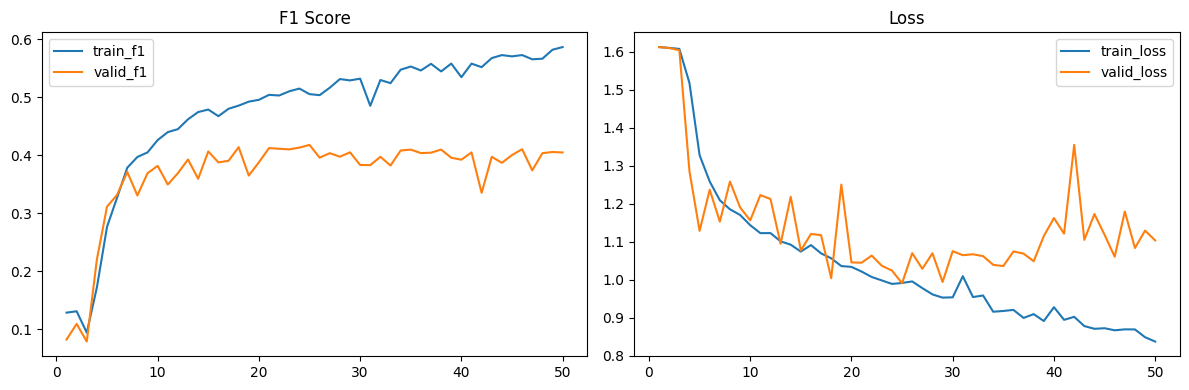

In [ ]:
epoch_count = range(1, len(hist_2.history['f1_score']) + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.lineplot(x=epoch_count,  y=hist_2.history['f1_score'], label='train_f1')
sns.lineplot(x=epoch_count,  y=hist_2.history['val_f1_score'], label='valid_f1')
plt.title('F1 Score')
plt.subplot(1,2,2)
sns.lineplot(x=epoch_count,  y=hist_2.history['loss'], label='train_loss')
sns.lineplot(x=epoch_count,  y=hist_2.history['val_loss'], label='valid_loss')
plt.title('Loss')
plt.tight_layout()
plt.show()

In [ ]:
def text_to_rating(review,model,tokenizer):
    review = review
    review = review.lower()
    model = model_2
    review_tokens = text_to_word_sequence(review)
    review_sequences = tokenizer.texts_to_sequences([review_tokens])
    maxlen = 116
    padded_sequences = pad_sequences(review_sequences, maxlen=maxlen ,  padding='post')

    # Realizo la predicción con el modelo
    predictions = model.predict(padded_sequences)
    print(predictions)
    # Obtengo la clase predicha
    predicted_class = np.argmax(predictions, axis=1)[0]

    print(f"El rating será de",predicted_class+1)


In [ ]:
review1 = 'the clothes are the worst i ever try'
rating = text_to_rating(review1,model_2,tokenizer)

1/1 [==============================] - 1s 974ms/step
[[0.8585192  0.1005254  0.03465671 0.00441207 0.00188659]]
El rating será de 1


In [ ]:
review2 = 'i absolutely love your clothes, they are all great'
rating = text_to_rating(review2,model_2,tokenizer)

1/1 [==============================] - 0s 24ms/step
[[0.0172736  0.00278159 0.02813398 0.35601407 0.5957967 ]]
El rating será de 5


In [ ]:
review3 = 'the clothes should be less expensive. The price is not related to the quality'
rating = text_to_rating(review3,model_2,tokenizer)

1/1 [==============================] - 0s 23ms/step
[[0.10125659 0.635937   0.22843437 0.02852339 0.00584866]]
El rating será de 2
